In [1]:
# import all packages
import corner,emcee
import pandas
import matplotlib.pyplot as plt
import numpy as np

In [2]:
###INSERT YOUR CHI-SQUARE RESULTS HERE: (Should be an array of length 3)
chisq_result=np.array([2.15044524, -5.87634607,  9.79198541])

In [3]:
# read in some data we created for this example (.dat is a generic filename, it's just a text file)
example_data_1D = pandas.read_csv('1D_intro_examples.dat',sep=',',header=0)#this file is separated by spaces and its first line contains the names of the columns (header) 
print(example_data_1D.head())

   Unnamed: 0         x          y     error
0           0  0.000000  11.890299  5.250000
1           1  0.714286   5.835328  5.350000
2           2  1.428571   6.468268  5.592857
3           3  2.142857  -1.355310  5.978571
4           4  2.857143  13.266424  6.507143


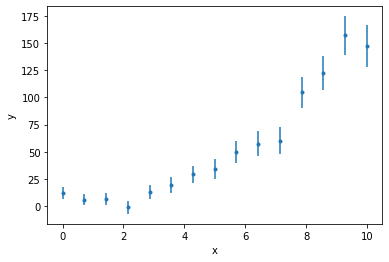

In [4]:
#Let's plot the data, with error bars, that we read from file (See Day 2)
plt.errorbar(example_data_1D['x'], #x,y,and error are the column names
             example_data_1D['y'], 
             yerr=example_data_1D['error'],#yerr denotes an error in the y-direction for plotting
             fmt='.') #fmt is "format", saying that I want data marked by "points"
plt.xlabel('x') #set the x-axis label 
plt.ylabel('y') #set the y-axis label
plt.show()

In [5]:
#The data were generated with a simple quadratic equation:
#ax^2+bx+c. The true model values are:
a_true=1.4
b_true=.4
c_true=2.5
def my_model(x,a,b,c): #We define the model described above
    return(a*x**2+b*x+c)

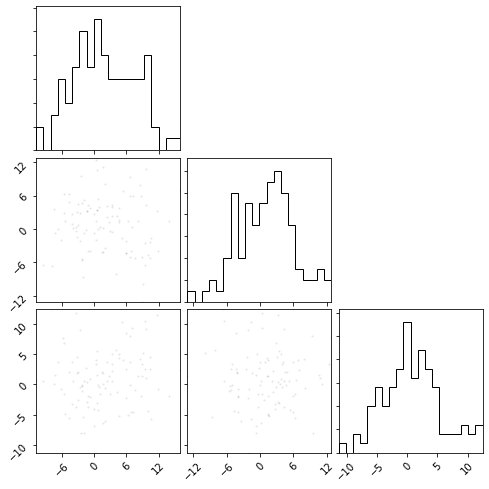

In [32]:
# We can combine a likelihood function with a prior function.
def chisq_likelihood(theta, args):
    #This function accepts an argument "theta", which is 
    #a list of model parameters a, b and c. It then calculates
    #a chi-square statistic that it returns, which compares
    #the observations, errors, and model provided in args.
    
    x, y, yerr,mod = args #args is a list, so this is the same as x=args[0],y=args[1],yerr=args[2]. x,y, and yerr are numpy arrays, mod is a function.
    a,b,c = theta #theta is also a list, so it follows the same as args above
    model_observations = mod(x,a,b,c) #mod (a model) is the 4th element of args, and it accepts x values, and the three model parameters a,b,c. Now model_observations contains the model values at every point in x (and is a numpy array)
    inv_sigma2 = 1./yerr**2 #The chi-square statistic contains an inverse-square error, which we calculate here
    chisquare = np.sum((y-model_observations)**2*inv_sigma2 )#calculate the chi-square statistic. 
    return chisquare

# Create a log-prior function. 
def lnprior(theta):#accepts the model parameters (theta)
    a,b,c = theta #set a,b,c (see above)
    
    #give the following bounds: a=(0,5),b=(-5,5),c=(0,10)
    if -20 < a < 20. and -20 < b < 20 and -20 < c < 20: #we are assuming a "uniform prior" on all parameters, which is the same as just giving each parameter bounds.
        return 0.0 #if you try parameters inside the bounds, return a probability of 1 (log(1)=0)
    return -np.inf #if you try parameters outside the bounds, return 0 (log(0)=-inf)

# This is a log-likelihood function, which is commonly used.
def lnprob(theta, x, y, yerr,mod): #accepts theta (the model parameters), and the same x,y,yerr, and mod from above
    lp = lnprior(theta) #get the probability from the prior function
    if not np.isfinite(lp): 
        return -np.inf #return a probability of negative infinity if the prior is negative infinity

    #the chisq_likelihood function returns a chi-square, 
    #which you want to be as small as possible. We are 
    #maximizing the likelihood here, so we take
    #the negative of the chi-square function.
    return lp - chisq_likelihood(theta, [x, y, yerr,mod]) #the total likelihood is the product of the prior and the likelihood (or the sum of the log-prior and log-likelihood)


#Set up the MCMC to sample the full parameter space
ndim, nwalkers = 3, 100 #number of parameters to fit (3); number of individual "walkers" that randomly sample the space. Choose any number, the higher the slower.
best_guess_parameters = np.array([1,1,1])
starting_positions = [best_guess_parameters + 5*np.random.randn(ndim) for i in range(nwalkers)] #Start the walkers in a random (small) gaussian near the result from the chi-square fit
corner.corner(starting_positions,plot_contours=False,plot_density=False,plot_datapoints=True)
#Let's just look at where walkers are starting in the a-b parameter space
#(Doesn't need to be included in your own code)
#Notice we get a random sampling near our previous result to start. 
#plt.scatter([x[0] for x in starting_positions],#get the "a" parameter locations
            #[x[1] for x in starting_positions])#get the "b" parameter locations
#plt.scatter(chisq_result[0],chisq_result[1],color='r')#the chi-square result
#plt.xlabel('a')
#plt.ylabel('b')
plt.show()


In [33]:
#set up the MCMC sampler
sampler = emcee.EnsembleSampler(nwalkers, 
                                ndim, 
                                lnprob, #the likelihood function to maximize 
                                args=(example_data_1D['x'], #the arguments passed to the likelihood functions (other than the model parameters)
                                      example_data_1D['y'], 
                                      example_data_1D['error'],
                                      my_model))

output = sampler.run_mcmc(starting_positions, 100) #run the MCMC with the starting positions we defined and 500 sampling points per walker

In [34]:
#sampler.chain contains all of the samples from the MCMC.
print(sampler.chain.shape)
#It currently holds the samples separately for each walker.
#We don't care about what each walker does, so let's flatten it:
samples = sampler.chain.reshape((-1, ndim)) #The -1 here means we don't care how many rows it takes, give us the same number of columns as we have parameters
print(samples.shape)
#So we tried 50000 total model realizations for 3 parameters

(100, 100, 3)
(10000, 3)


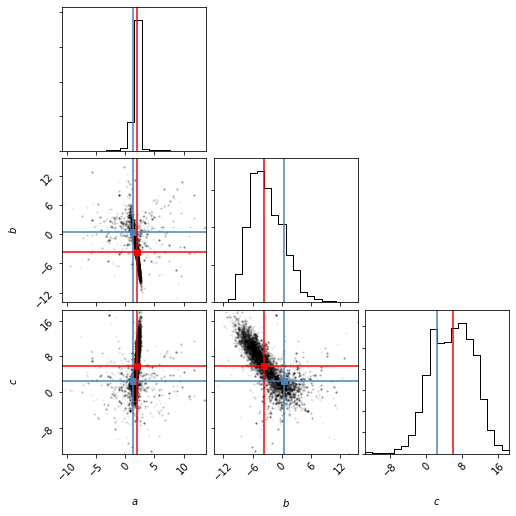

In [51]:
#So what did we actually get from this? Let's use another
#python package to see the output of the MCMC sampling
fig = corner.corner(samples, #samples is defined above
                    labels=["$a$", "$b$","$c$"],#parameter labels
                    truths=[a_true, b_true,c_true],#show the true values for comparison
                    plot_contours=False,plot_density=False,
                    plot_datapoints=True)
fig = corner.corner(samples, #samples is defined above
                    labels=["$a$", "$b$","$c$"],#parameter labels
                    truths=np.percentile(samples, 50,axis=0),#show the true values for comparison
                    plot_contours=False,plot_density=False,truth_color='red',
                    fig=fig,
                    plot_datapoints=False)

plt.show()

1.9531033066372077 -3.545746695580341 5.900778614837451


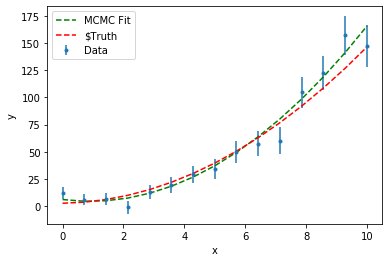

In [36]:
#But how close did we get to the true values?
#We can take the 50th percentile of the distributions you see above
#As our result. Incidentally we could calculate the uncertainty as 
#well, perhaps as the differences between the 84th and 50th for
#the upper uncertainty, and 50th and 16th for the lower uncertainty
a_mcmc, b_mcmc,c_mcmc = np.percentile(samples, 50,axis=0)#axis=0 means we want to calculate percentiles along columns, not rows
#set up plotting the model over the data
print(a_mcmc,b_mcmc,c_mcmc)
plt.errorbar(example_data_1D['x'],
             example_data_1D['y'],
             yerr=example_data_1D['error'],
             fmt='.',
             label='Data')

plt.plot(example_data_1D['x'],
         my_model(example_data_1D['x'],a_mcmc,b_mcmc,c_mcmc),
         'r--',#make the line green and dashed
         label='MCMC Fit')
plt.plot(example_data_1D['x'],
         my_model(example_data_1D['x'],a_true,b_true,c_true),
         'b--',#make the line green and dashed
         label='Truth')



plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.show()